## Exploratory Data Analysis 

In [37]:
import numpy as np
import pandas as pd     
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_csv("latimes-county-totals.csv")

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df.info()

In [9]:
df2 = df.copy(deep=True)
df_la = df2[df2['county'] == 'Los Angeles']
# df_la.head()

In [10]:
df_la = df_la.drop(labels=['fips'], axis=1)
# print (df_la.info())
# df_la.describe()

In [11]:
#replace the only two NAs in the first day of new_confirmed_cases and new_deaths to 0
df_la = df_la.fillna(0)

In [12]:
days = list(range(1,len(df_la)+1))
df_la['culm_day'] = days

In [ ]:
df_la.describe()

In [ ]:
df_la.columns

In [ ]:
df_la.corr(min_periods=1)

Correlation between deaths and confirmed_cases is the highest 0.99. Although it makes sense how having a high number of confirmed cases means more people are infected therefore increasing the number of deaths, the correlation is too high and maybe due to having a small dataset, with 100 rows for Los Angeles only.

In [ ]:
#only Los Angeles
plot_df_la = df_la.dropna()
sns.pairplot(plot_df_la)

In [ ]:
sns.distplot(df_la['confirmed_cases'], hist=False,rug=True, kde_kws={'shade':True})

In [ ]:
sns.distplot(df_la['new_confirmed_cases'], hist=False,rug=True, kde_kws={'shade':True})

In [ ]:
sns.distplot(df_la['deaths'], hist=False,rug=True, kde_kws={'shade':True})

In [ ]:
sns.distplot(df_la['new_deaths'], hist=False)

In [ ]:
sns.regplot(x="culm_day", y="confirmed_cases", data=df_la,fit_reg=False).set_title("COVID19 infections from the first confirmed case in LA")

In [ ]:
sns.regplot(x="culm_day", y="new_confirmed_cases", data=df_la, fit_reg=False).set_title("COVID19 new confirmed cases from the first confirmed case in LA")

As culmulative days increase, we see the numbers of new confirmed cases increase, dropped a bit and then went back up again, probably due to having enough testing kits.

In [ ]:
sns.regplot(x="culm_day", y="deaths", data=df_la,fit_reg=False).set_title("COVID19 deaths from the first confirmed case in LA")

The deaths continues to increase in LA. We do not see a turning point yet.

In [ ]:
sns.regplot(x="culm_day", y="new_deaths", data=df_la, fit_reg=False).set_title("COVID19 new deaths from the first confirmed case in LA")

In [ ]:
sns.regplot(x="confirmed_cases", y="new_deaths", data=df_la, fit_reg=False).set_title("COVID19 confirmed cases vs new deaths in LA")

In [ ]:
sns.regplot(x="confirmed_cases", y="deaths", data=df_la, fit_reg=False).set_title("COVID19 confirmed cases vs deaths in LA")

There is a positive correlation between the total numbers of confirmed cases and deaths. The relationship looks linear from this plot.

In [ ]:
sns.regplot(x="new_deaths", y="deaths", data=df_la, fit_reg=False).set_title("COVID19 new deaths vs deaths in LA")

The numbers of cumulative deaths seem to be positively correlated with the number of new_deaths, however, can't tell the shape of relationship between the two. Will need more data points in order to find out the true relationship.

In [ ]:
confirmed_total_date = df_la.groupby(['date']).agg({'confirmed_cases':['sum']})
fatalities_total_date = df_la.groupby(['date']).agg({'deaths':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

In [ ]:
#side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("LA total confirmed cases", size=13)
ax1.set_ylabel("Number of confirmed cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("LA total deaths", size=13)
ax2.set_ylabel("Number of deaths", size=13)
ax2.set_xlabel("Date", size=13)

In [ ]:
confirmed_total_date = df_la.groupby(['culm_day']).agg({'confirmed_cases':['sum']})
fatalities_total_date = df_la.groupby(['culm_day']).agg({'deaths':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

In [ ]:
#same as plots above, just trying to use days to replace date for exploration
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("LA total confirmed cases", size=13)
ax1.set_ylabel("Number of confirmed cases", size=13)
ax1.set_xlabel("days", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("LA total deaths", size=13)
ax2.set_ylabel("Number of deaths", size=13)
ax2.set_xlabel("days", size=13)

The left plot shows the total confirmed cases in LA compared with the total deaths as of 5/4/2020. We do not see a turning point in LA yet. The right is a zoomed in of the total death in LA, sharing a similar shape as the number of confirmed cases.

## Simulation 

In [ ]:
def SEIRD_model(N, E, I, r, r2, re, r2e, p, d, shelter_in_place, b, b2, y, a, days):
    '''
    N - Total population，N = I + S + R + E 
    S - Number of people that are Susceptibles
    R - Number of people that are Recovered
    E - Number of people that are Exposed
    I - Number of people that are Infected
    r - The number of people each infected contacts each day
    re - New r after shelter in place
    r2 - The number of people each asymptomatic contacts each day
    r2e - New r2 after shelter in place takes effect
    p - Protection rate of the masks. After shelter in place, b=b*p, b2 = b2*p
    d - The proportion of infected who die each day to the total number of infected people
    shelter_in_place - Days since shelter in place
    b - Probability of transmission from infected to susceptible person
    b2 Probability of transmission from asymptomatic to susceptible
    y - The proportion of infected who are recovered each day to the total number of infected people
    a - Probability of susceptible transforming to infected
    days - Duration in days
    '''
    S = N - I - E
    I_list = [I]
    S_list = [S]
    E_list = [E]
    R_list = [0]
    D_list = [0]
    C_list = [0] # Confirmed list 

    for i in range(1, days):
        if (i + 1) == shelter_in_place:
            r, r2, b, b2,a = re, r2e, b * p, b2 * p, a*p
        E_perday = r * b * I_list[i - 1] * S_list[i - 1]/N
        E_perday_for_E = r2 * b2 * E_list[i - 1] * S_list[i - 1]/N
        I_perday = a * E_list[i - 1]
        R_perday = y * I_list[i - 1]
        D_perday = d * I_list[i - 1]
        C_list.append(C_list[i - 1] + I_perday)
        I_list.append(I_list[i - 1] + I_perday - R_perday - D_perday)
        S_list.append(S_list[i - 1] - E_perday - E_perday_for_E)
        R_list.append(R_list[i - 1] + R_perday)
        D_list.append(D_list[i - 1] + D_perday)
        E_list.append(E_list[i - 1] + E_perday + E_perday_for_E - I_perday)
    newlist = [I_list,S_list,E_list,R_list,D_list,C_list,days]
    return newlist

Start with smaller N

In [ ]:
N = 10000
E = 0
I = 1
r = 20
r2 = 20
re = 5
r2e = 5
p = 0.8
d = 0.01
shelter_in_place = 10
b = 0.03
b2 = 0.03
y = 0.1
a = 0.1
days =140
result = SEIRD_model(N, E, I, r, r2, re, r2e, p, d, shelter_in_place, b, b2, y, a, days)

In [ ]:
# create a list of tagged_day for labeling x-axis
day_cul = list(range(1,result[6]+1))

In [ ]:
# full plot of the small set
plt.clf()
fit = plt.figure()
# plot x = days, y = I_lisst
plt.scatter(x=day_cul , y = result[0], marker = '.', color = 'blue', label = 'Infected')

#plot x = days, y = S_list
plt.scatter(x=day_cul , y = result[1], marker = '.', color = 'chartreuse',label = 'Susceptible' )

#plot x = days, y = E_list
plt.scatter(x=day_cul , y = result[2], marker = '.', color = 'orange',label = 'Exposed' )

#plot x = days, y = R_list
plt.scatter(x=day_cul , y = result[3], marker = '.', color = 'green',label = 'Recovered' )

#plot x = days, y = D_list
plt.scatter(x=day_cul , y = result[4], marker = '.', color = 'black',label = 'Deaths' )

#plot x = days, y = C_list
plt.scatter(x=day_cul , y = result[5], marker = '.', color = 'red',label = 'Confirmed' )

plt.title("SEIRD Model")
plt.xlabel("Time in days")
plt.legend(loc="best")
plt.ylabel("Number of individuals")

In [ ]:
## Simlation of LA county
#LA county population: 10.04 million (2019)
#We will use the population from last year for this model
#100 days model
#LA had its first confirmed case on 2020-01-26
#Started shelter in place around 2020-03-20
#shelter in place: the day that shelter in place enforce: 54 days

N = 10400000
E = 0
I = 1
r = 8
r2 = 8
re = 1
r2e = 1
p = 0.8
d = 0.01
shelter_in_place = 54
b = 0.03
b2 = 0.03
y = 0.15
a = 0.1
days =100
result = SEIRD_model(N, E, I, r, r2, re, r2e, p, d, shelter_in_place, b, b2, y, a, days)

In [ ]:
day_cul = list(range(1,result[6]+1))

In [ ]:
# plot of predicted death of LA county using the simulation model
plt.clf()
fit = plt.figure()
# plot x = days, y = I_lisst
# plt.scatter(x=day_cul , y = result[0], marker = '.', color = 'blue', label = 'Infected')

#plot x = days, y = S_list
#plt.scatter(x=day_cul , y = result[1], marker = '.', color = 'chartreuse',label = 'Susceptible' )

#plot x = days, y = E_list
#plt.scatter(x=day_cul , y = result[2], marker = '.', color = 'orange',label = 'Exposed' )

#plot x = days, y = R_list
#plt.scatter(x=day_cul , y = result[3], marker = '.', color = 'green',label = 'Recovered' )

#plot x = days, y = D_list
plt.scatter(x=day_cul , y = result[4], marker = '.', color = 'black',label = 'Deaths' )

#plot x = days, y = C_list
#plt.scatter(x=day_cul , y = result[5], marker = '.', color = 'red',label = 'Confirmed' )

plt.title("SEIRD Model")
plt.xlabel("Time in days")
plt.legend(loc="best")
plt.ylabel("Number of individuals")

## Logistics Model

In [13]:
df_la

,date,county,confirmed_cases,deaths,new_confirmed_cases,new_deaths,culm_day
867,1/26/20,Los Angeles,1,0,0.0,0.0,1
868,1/27/20,Los Angeles,1,0,0.0,0.0,2
869,1/28/20,Los Angeles,1,0,0.0,0.0,3
870,1/29/20,Los Angeles,1,0,0.0,0.0,4
871,1/30/20,Los Angeles,1,0,0.0,0.0,5
...,...,...,...,...,...,...,...
962,4/30/20,Los Angeles,23233,1119,711.0,54.0,96
963,5/1/20,Los Angeles,24262,1174,1029.0,55.0,97
964,5/2/20,Los Angeles,24936,1212,674.0,38.0,98
965,5/3/20,Los Angeles,25699,1231,763.0,19.0,99


In [14]:
X = df_la.drop(['deaths','date'], axis=1)
y = df_la['deaths']

In [16]:
#split dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
#defin logistic funtion 
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

Use curve_fit to autmatically find the best value for parameters a,b,c
Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized

In [20]:
# find the best parameter using training set
fit = curve_fit(logistic_model,X_train['culm_day'],y_train)
fit

(array([   7.29784855,   88.47819366, 1510.98406416]),
 array([[1.46895217e-02, 2.62270400e-02, 2.20513537e+00],
        [2.62270400e-02, 6.44350807e-02, 5.17654228e+00],
        [2.20513537e+00, 5.17654228e+00, 4.38692825e+02]]))

In [21]:
# use test set to evalute model
test_result = logistic_model(X_test['culm_day'],7.29784855,88.47819366,1510.98406416)

In [22]:
# calculate MSE of test_result vs y_test
mean_squared_error(y_test, test_result)

134.2841134757969

In [32]:
# calculate rmse
rmse = np.sqrt(mean_squared_error(y_test, test_result))
rmse

11.588102237890244

In [39]:
#mae
mean_absolute_error(y_test, test_result)

6.7242081038318755

In [40]:
# predict 100 days death using logistic model
days = list(range(1,101))
new_culm = pd.DataFrame(days)
result_new_culm = logistic_model(new_culm,7.29784855,88.47819366,1510.98406416)

In [41]:
# calculate MSE 

mean_squared_error(y, result_new_culm)

118.22134475408231

In [44]:
# root mse
rmse = np.sqrt(mean_squared_error(y, result_new_culm))
rmse

10.872963936024174

In [45]:
# mae
mean_absolute_error(y, result_new_culm)

7.11572782134099

<Figure size 432x288 with 0 Axes>

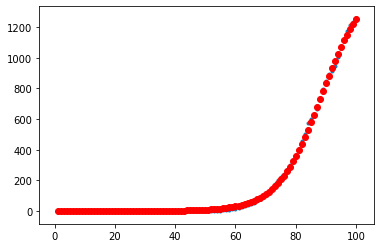

In [46]:
plt.clf()
fit = plt.figure()
# plot x = day, y = actual death
plt.scatter(x=df_la['culm_day'] , y = y, marker = '.' )

#plot for the extra 100 days
plt.scatter(x=days, y = result_new_culm, color = 'red' )